# Dynamic Ensembles using metaforecast: Coupling ADE with mlforecast

ADE is a metalearning approach for combining forecasts based on loss predictions produced by a meta-model.

This notebook explores how to use ADE with mlforecast's awesome framework 

1. Loading M3's monthly dataset
2. Preparing and running several regression models using mlforecast
3. Fitting ADE - a combination rule based on meta-learning
4. Getting forecasts and combining them using ADE
5. Evaluating all models

In [1]:
import warnings

warnings.filterwarnings("ignore")

If necessary, install the package using pip:

In [2]:
# !pip install metaforecast

# 1. Data preparation

Let's start by loading the dataset.
This tutorial uses the M3 monthly dataset available on datasetsforecast.

We also set the forecasting horizon and input size (number of lags) to 12.

In [3]:
import pandas as pd

from datasetsforecast.m3 import M3

# ade is best suited for short-term forecasting
horizon = 3
n_lags = 12

df, *_ = M3.load('.',group='Monthly')

Split the dataset into training and testing sets:

In [4]:
df_by_unq = df.groupby('unique_id')

train_l, test_l = [], []
for g, df_ in df_by_unq:
    df_ = df_.sort_values('ds')

    train_df_g = df_.head(-horizon)
    test_df_g = df_.tail(horizon)

    train_l.append(train_df_g)
    test_l.append(test_df_g)

train_df = pd.concat(train_l).reset_index(drop=True)
test_df = pd.concat(test_l).reset_index(drop=True)

train_df.query('unique_id=="M1000"').tail()

,unique_id,ds,y
322,M1000,1993-07-31,4640.4
323,M1000,1993-08-31,4656.0
324,M1000,1993-09-30,4665.8
325,M1000,1993-10-31,4687.4
326,M1000,1993-11-30,4695.4


In [5]:
test_df.query('unique_id=="M1000"').head()

,unique_id,ds,y
9,M1000,1993-12-31,4669.4
10,M1000,1994-01-31,4669.8
11,M1000,1994-02-28,4663.6


# 2. Model setup and fitting

Let's start by setting up the ensemble members: 9 regression algorithms based on scikit-learn, lightgbm and xgboost.
These are trained using Nixtla's mlforecast.

In [6]:
from mlforecast import MLForecast

import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

models_ml = {
    'Ridge': RidgeCV(),
    'Lasso': LassoCV(),
    'Elastic-net': ElasticNetCV(),
    'DT': DecisionTreeRegressor(max_depth=5),
    'DStump': DecisionTreeRegressor(max_depth=1),
    'RF': xgb.XGBRFRegressor(n_estimators=25),
    'KNN': KNeighborsRegressor(n_neighbors=30),
    'LGB': lgb.LGBMRegressor(verbosity=-1, n_jobs=1),
    'LGBlinear': lgb.LGBMRegressor(verbosity=-1, n_jobs=1, linear_tree=True),
}

mlf = MLForecast(
    models=models_ml,
    freq='ME',
    lags=range(1, n_lags + 1),
)

# make sure fitted=True so we have samples for meta-learning
mlf.fit(df=train_df, fitted=True)

MLForecast(models=[Ridge, Lasso, Elastic-net, DT, DStump, RF, KNN, LGB, LGBlinear], freq=ME, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12'], date_features=[], num_threads=1)

# 3. Fitting ADE

Now, we can fit ADE meta-model using MLForecastADE's class, which takes a trained MLForecast object as the main input.

In [7]:
from metaforecast.ensembles.ade import MLForecastADE

?MLForecastADE

2024-10-08 14:19:48,432	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-10-08 14:19:48,578	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Init signature:
MLForecastADE(
    mlf: mlforecast.forecast.MLForecast,
    sf: Optional[statsforecast.core.StatsForecast] = None,
    trim_ratio: float = 1,
    meta_model=MultiOutputRegressor(estimator=LGBMRegressor(linear_tree=True, n_jobs=1,
                                             verbosity=-1)),
)
Docstring:     
MLForecastADE

ADE based on a MLForecast object
Init docstring:
:param mlf: MLForecast object containing multiple models to form the ensemble
:type mlf: MLForecast

:param sf: A StatsForecast object containing classical forecasting models to be added to the ensemble
:type sf: StatsForecast object

:param trim_ratio: Ratio (0-1) of ensemble members to keep in the ensemble.
(1-trim_ratio) of models will not be used during inference based on validation accuracy.
Defaults to 1, which means all ensemble members are used.
:type trim_ratio: float

:param meta_model: Learning algorithm to use in the meta-level to forecast the error of ensemble members.
Defaults to a linear L

In [8]:
ade = MLForecastADE(mlf=mlf, trim_ratio=0.5)

In [9]:
ade.fit()

In [10]:
fcst_base = mlf.predict(h=horizon)

fcst_base.head()

,unique_id,ds,Ridge,Lasso,Elastic-net,DT,DStump,RF,KNN,LGB,LGBlinear
0,M1,1995-06-30,2149.469747,2172.311248,2173.336073,2540.632673,3962.632074,2532.610352,2271.558333,2192.984792,3110.076436
1,M1,1995-07-31,1983.188764,1998.960779,2001.338125,2540.632673,3962.632074,2355.043945,1974.211667,2264.615053,3303.649414
2,M1,1995-08-31,2059.446128,2131.560249,2131.680321,2540.632673,3962.632074,2394.086182,1830.160000,1967.978750,2248.087972
3,M10,1995-06-30,4433.691118,4438.551141,4436.222796,3875.245900,3962.632074,4251.751953,4289.333333,4286.798414,4296.983840
4,M10,1995-07-31,4585.222697,4599.350498,4596.886585,4727.637243,3962.632074,4461.590820,4372.906667,4320.767589,4362.007041


In [11]:
fcst_ade = ade.predict(train=train_df, h=horizon)

fcst_base['ADE'] = fcst_ade

fcst_base.head()

,unique_id,ds,Ridge,Lasso,Elastic-net,DT,DStump,RF,KNN,LGB,LGBlinear,ADE
0,M1,1995-06-30,2149.469747,2172.311248,2173.336073,2540.632673,3962.632074,2532.610352,2271.558333,2192.984792,3110.076436,2440.176198
1,M1,1995-07-31,1983.188764,1998.960779,2001.338125,2540.632673,3962.632074,2355.043945,1974.211667,2264.615053,3303.649414,2396.274191
2,M1,1995-08-31,2059.446128,2131.560249,2131.680321,2540.632673,3962.632074,2394.086182,1830.160000,1967.978750,2248.087972,2029.625712
3,M10,1995-06-30,4433.691118,4438.551141,4436.222796,3875.245900,3962.632074,4251.751953,4289.333333,4286.798414,4296.983840,4280.256254
4,M10,1995-07-31,4585.222697,4599.350498,4596.886585,4727.637243,3962.632074,4461.590820,4372.906667,4320.767589,4362.007041,4381.604653


Below are the weights of each model (equal across all unique ids because weight_by_uid=False)

Then, we refit the neural networks are get the test forecasts

# 4. Evaluation

Finally, we compare all approaches

In [12]:
test_df = test_df.merge(fcst_base, on=['unique_id','ds'], how="left")

In [13]:
# accuracy func doesn't like "-"
test_df = test_df.rename(columns={'Elastic-net':'Elasticnet'})

In [14]:
from neuralforecast.losses.numpy import smape
from datasetsforecast.evaluation import accuracy

evaluation_df = accuracy(test_df, [smape], agg_by=['unique_id'])

In [15]:
eval_df = evaluation_df.drop(columns=['metric','unique_id'])

eval_df

,Ridge,Lasso,Elasticnet,DT,DStump,RF,KNN,LGB,LGBlinear,ADE
0,0.550694,0.561228,0.560943,0.711984,1.047424,0.667910,0.524537,0.565304,0.792120,0.614334
1,0.257638,0.259569,0.259007,0.212828,0.154263,0.229246,0.223332,0.214010,0.222607,0.222518
2,0.190249,0.187620,0.187266,0.087864,0.389560,0.134822,0.186286,0.182240,0.164353,0.181241
3,0.005375,0.006757,0.006742,0.012781,0.163372,0.016654,0.011551,0.010891,0.013910,0.013245
4,0.021460,0.016805,0.016895,0.024350,0.063866,0.006752,0.015896,0.014463,0.018123,0.013815
...,...,...,...,...,...,...,...,...,...,...
1423,0.012926,0.008199,0.008270,0.041589,0.046636,0.021763,0.017380,0.005696,0.014001,0.014724
1424,0.029931,0.024811,0.024881,0.047401,0.031377,0.030224,0.018823,0.028110,0.033240,0.027491
1425,0.108043,0.105993,0.106070,0.051117,0.235251,0.060142,0.038777,0.087354,0.081680,0.067245
1426,0.015453,0.018603,0.018564,0.034756,0.135385,0.006849,0.005117,0.004888,0.006411,0.004767


<Axes: >

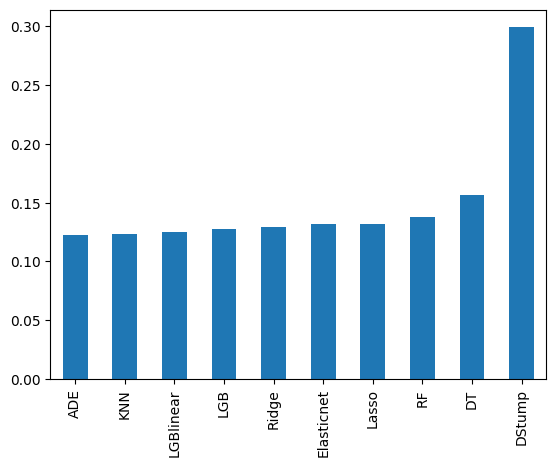

In [16]:
eval_df.mean().sort_values().plot.bar()